In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords

import string

import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes

color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words('english')) #영어에서의 불용어들
pd.options.mode.chained_assignment = None

In [2]:
import zipfile

extract_to_path = '/kaggle/working/'
zip_file_path = '/kaggle/input/spooky-author-identification/train.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)
zip_file_path = '/kaggle/input/spooky-author-identification/test.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

In [3]:
train = pd.read_csv('/kaggle/working/train.csv')
test = pd.read_csv('/kaggle/working/test.csv')
print('Number of rows in train dataset: ', train.shape[0])
print('Number of rows in test dataset: ', test.shape[0])

Number of rows in train dataset:  19579
Number of rows in test dataset:  8392


In [4]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


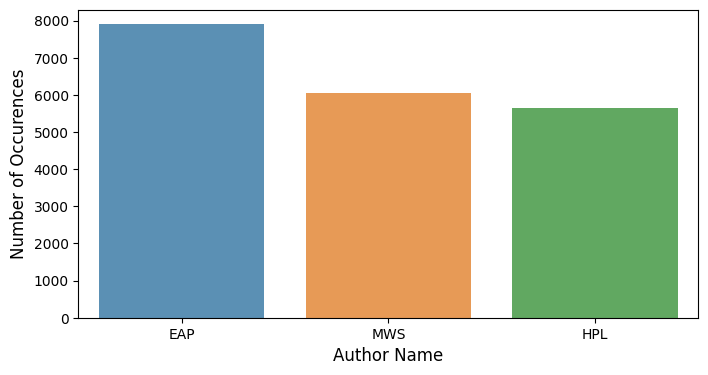

In [5]:
cnt_srs = train['author'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [6]:
grouped_df = train.groupby('author')
for name, group in grouped_df:
    print('Author name: ', name)
    cnt = 0
    for idx, row in group.iterrows():
        print(f"#{cnt+1}:{row['text']}")
        cnt += 1
        if  cnt == 5:
            break
    print('\n')

Author name:  EAP
#1:This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.
#2:In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.
#3:The astronomer, perhaps, at this point, took refuge in the suggestion of non luminosity; and here analogy was suddenly let fall.
#4:The surcingle hung in ribands from my body.
#5:I knew that you could not say to yourself 'stereotomy' without being brought to think of atomies, and thus of the theories of Epicurus; and since, when we discussed this subject not very long ago, I mentioned to you how singularly, yet with how little notice, the vague guesses of that noble Greek had met with confirmation in the late nebular cosmogony, I felt

### Meta features와 Text based features
1. Meta features는 텍스트 데이터의 **외부적인** 특성을 나타낸다. 주로 텍스트의 **형태적** 또는 **정보적** 측면을 반영한다. 예를 들면-
- 문서 길이
- 단어 수
- 문장 수
- 단어의 다양성
- 문장 평균 길이
- 특수문자 또는 구두점의 수 등

2. Text based features는 텍스트의 **내용적** 특성을 분석한 것으로, 텍스트 내에서 직접적으로 파생되는 특징이다. 주로 **단어 수준**에서 도출된다. 예를 들면-
- 단어 빈도(TF)
- TF-IDF
- N-gram : n개의 연속된 단어들로 이루어진 패턴 추출
- 단어 임베딩 : 단어를 고차원 벡터로 변환, 의미론적 관계 반영
- 감정 분석 : 긍정/부정/중립정 감정 기반으로 특성 생성
- 주제 모델링 : LDA와 같은 기법으로 문서 내 주요 주제를 추출
- 문법적 특성 : 텍스트의 구문적 구조를 분석하는 특성으로 구문 트리에서 얻은 정보나 품사 태깅을 포함할 수 있음


### Using meta features

In [7]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
print('word'.isupper())
print('WORD'.isupper())
print('Word'.isupper()) # 모두 대문자여야지만 True
print('word'.istitle())
print('WORD'.istitle())
print('Word'.istitle()) # 첫번째 글자만 uppercase여야 함

False
True
False
False
False
True


In [9]:
######Extracing Meta Features######

#문장 내 단어 수
train['num_words'] = train['text'].apply(lambda x:len(str(x).split()))
test['num_words'] = test['text'].apply(lambda x:len(str(x).split()))

#문장 내 unique한 단어 수 (set 활용)
train['num_unique_words'] = train['text'].apply(lambda x:len(set(str(x).split())))
test['num_unique_words'] = test['text'].apply(lambda x:len(set(str(x).split())))

#문장 내 character 수(알파벳 수) - simple length
train['num_chars'] = train['text'].apply(lambda x:len(str(x)))
test['num_chars'] = test['text'].apply(lambda x:len(str(x)))

#문장 내 불용어의 수 - nltk의 stopwords에서 정의된
train['num_stopwords'] = train['text'].apply(lambda x:len([w for w in str(x).lower().split() if w in eng_stopwords]))
test['num_stopwords'] = test['text'].apply(lambda x:len([w for w in str(x).lower().split() if w in eng_stopwords]))

#문장 내 구두점의 수 '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
train['num_punctuations'] = train['text'].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))
test['num_punctuations'] = test['text'].apply(lambda x:len([c for c in str(x) if c in string.punctuation]))

# isupper()
train['num_words_upper'] = train['text'].apply(lambda x:len([w for w in str(x).split() if w.isupper()]))
test['num_words_upper'] = test['text'].apply(lambda x:len([w for w in str(x).split() if w.isupper()]))

# istitle()
train['num_words_title'] = train['text'].apply(lambda x:len([w for w in str(x).split() if w.istitle()]))
test['num_words_title'] = test['text'].apply(lambda x:len([w for w in str(x).split() if w.istitle()]))

#문장 내 단어길이의 평균
train['mean_word_len'] = train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test['mean_word_len'] = test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [10]:
train.groupby('author')['num_words'].describe()

,count,mean,std,min,25%,50%,75%,max
author,,,,,,,,
EAP,7900.0,25.442405,18.567706,2.0,12.0,21.0,33.0,267.0
HPL,5635.0,27.799645,14.123252,4.0,18.0,26.0,35.0,147.0
MWS,6044.0,27.417273,23.134440,2.0,15.0,23.0,34.0,861.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


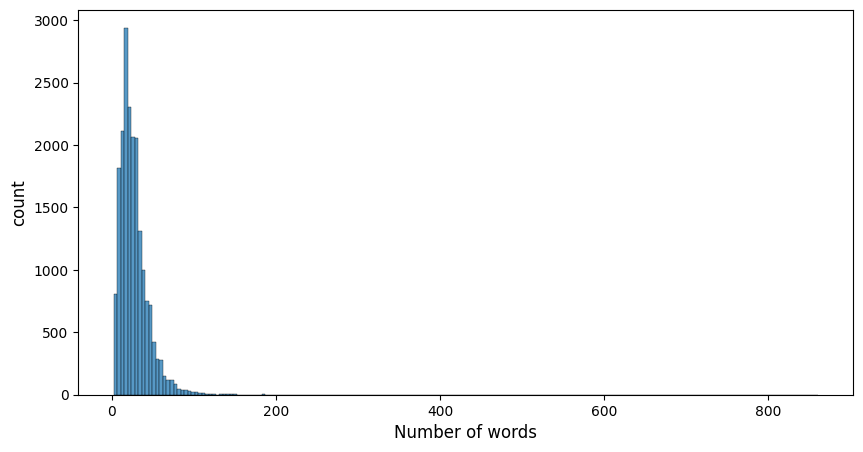

In [11]:
plt.figure(figsize=(10,5))
sns.histplot(train['num_words'], bins=200) #긴꼬리 분포
plt.ylabel('count', fontsize=12)
plt.xlabel('Number of words', fontsize=12)
plt.show()

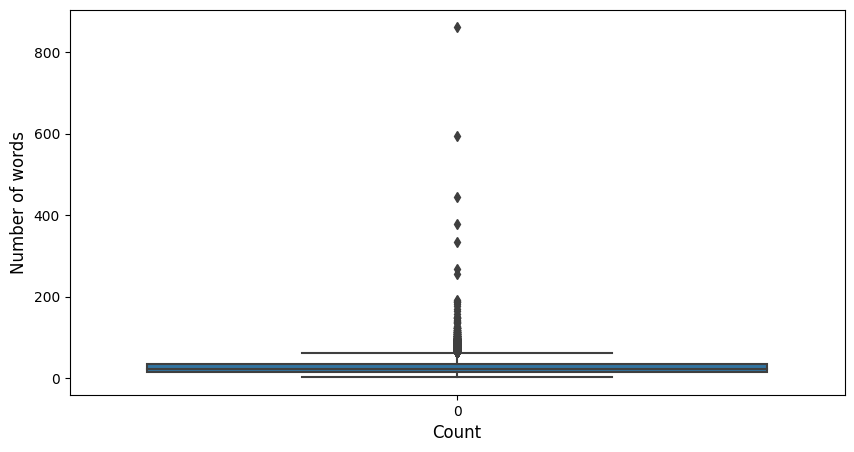

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(train['num_words']) #긴꼬리 분포
plt.ylabel('Number of words', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.show()

/tmp/ipykernel_103/3884026492.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train['num_words'].loc[train['num_words']>80] = 80 # Truncation


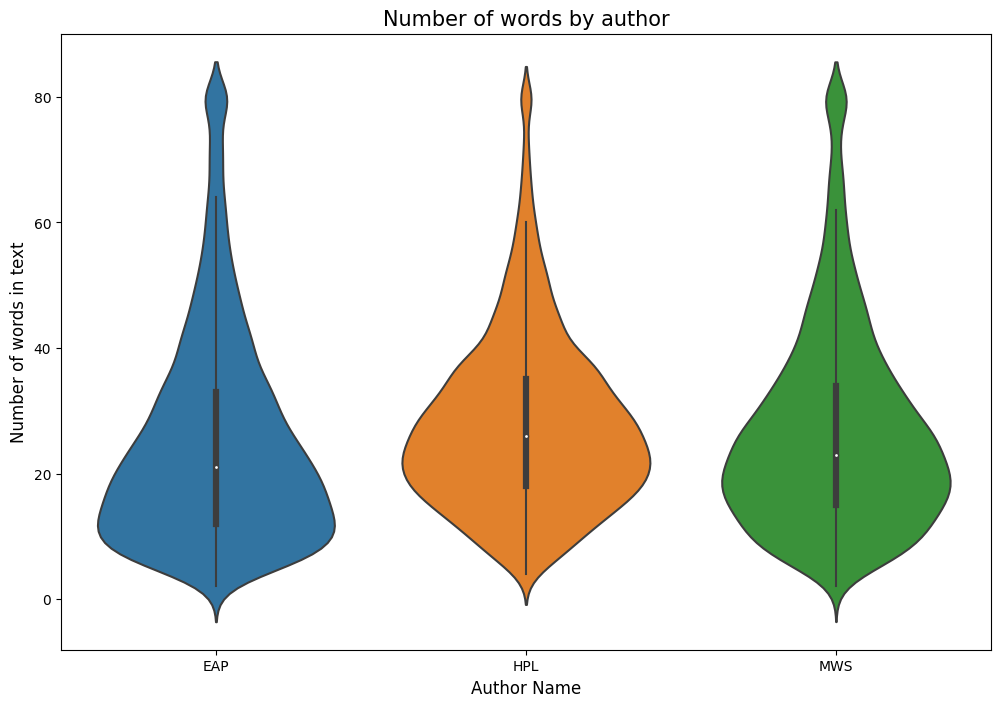

In [13]:
train['num_words'].loc[train['num_words']>80] = 80 # Truncation
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title('Number of words by author', fontsize=15)
plt.show() #80 부근이 다소 뭉툭해짐...

In [14]:
train.groupby('author')['num_punctuations'].describe()

,count,mean,std,min,25%,50%,75%,max
author,,,,,,,,
EAP,7900.0,4.096329,3.573788,1.0,2.0,3.0,5.0,71.0
HPL,5635.0,3.206921,2.108637,1.0,2.0,3.0,4.0,28.0
MWS,6044.0,3.833719,2.840625,1.0,2.0,3.0,5.0,59.0


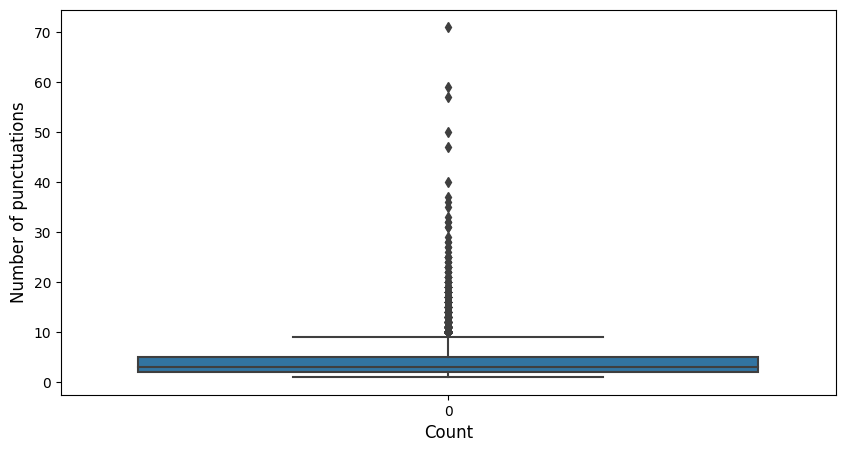

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(train['num_punctuations']) #긴꼬리 분포
plt.ylabel('Number of punctuations', fontsize=12)
plt.xlabel('Count', fontsize=12)
plt.show()

/tmp/ipykernel_103/539863330.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  train['num_punctuations'].loc[train['num_punctuations']>10] = 10 # Truncation


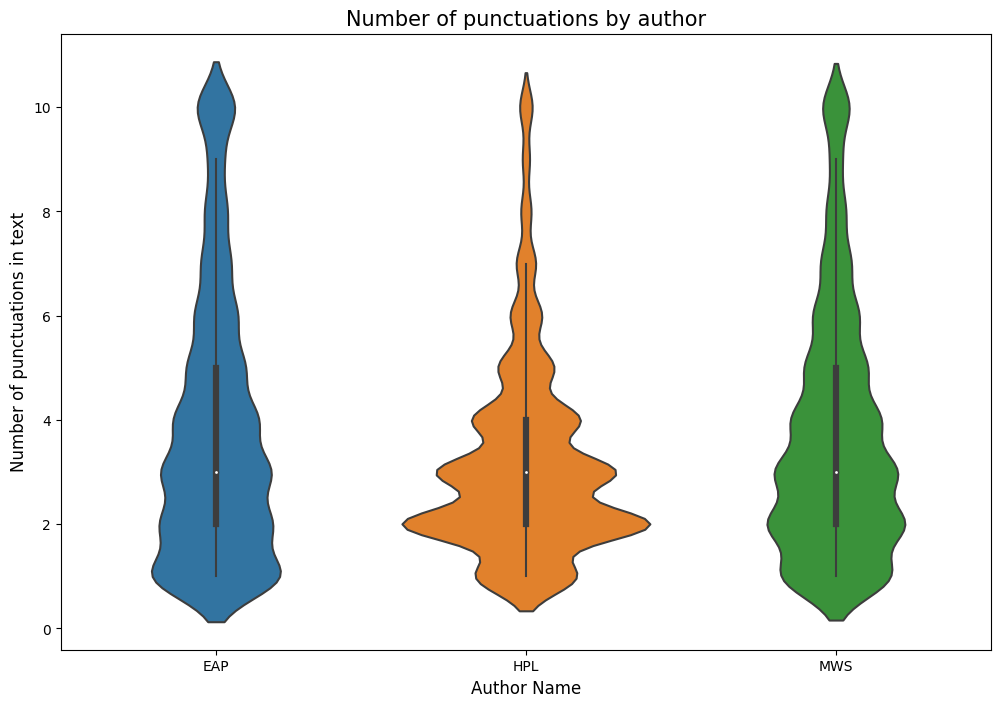

In [16]:
train['num_punctuations'].loc[train['num_punctuations']>10] = 10 # Truncation
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of punctuations in text', fontsize=12)
plt.title('Number of punctuations by author', fontsize=15)
plt.show()

In [17]:
## Prepare the data for modeling ###
author_mapping_dict = {'EAP':0, 'HPL':1, 'MWS':2}
train_y = train['author'].map(author_mapping_dict)
train_id = train['id'].values
test_id = test['id'].values

## threshold로 보정했던(truncate했던) 이상치 값들 다시 복원
train['num_words'] = train['text'].apply(lambda x: len(str(x).split()))
test['num_words'] = test['text'].apply(lambda x: len(str(x).split()))
train['mean_word_len'] = train['text'].apply(lambda x:np.mean([len(w) for w in str(x).split()]))
test['mean_word_len'] = test['text'].apply(lambda x:np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['id', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

Text based features 없이,
Meta features 만으로 작가 예측하는 머신러닝모델 시도

In [18]:
def runXGB(train_X, train_y, test_X, test_y = None, test_X2 = None, seed_val=0,
          child = 1, colsample=0.3):
    
    # 1. 파라미터 설정
    param = {}
    param['objective'] = 'multi:softprob' # objective: 다중 클래스 분류를 위한 설정 (multi:softprob은 각 클래스에 대한 확률을 출력).
    param['eta'] = 0.1 # eta: 학습률(learning rate)
    param['max_depth'] = 3 # max_depth: 트리의 최대 깊이.
    param['silent'] = 1 # silent: 학습 시 출력되는 로그의 양을 조절 (현재 버전에서는 verbosity로 대체됨)
    param['num_class'] = 3 # num_class: 클래스의 수 (여기서는 3개로 설정)
    param['eval_metric'] = 'mlogloss' # eval_metric: 평가 지표로 다중 클래스 로그 손실(mlogloss)을 사용.
    param['min_child_weight'] = child # min_child_weight: 트리의 가지치기 기준.
    param['subsample'] = 0.8 # subsample: 각 트리를 만들 때 사용할 데이터의 비율
    param['colsample_bytree'] = colsample # colsample_bytree: 각 트리를 만들 때 사용할 특징의 비율
    param['seed'] = seed_val # seed: 랜덤 시드 값.
    num_rounds = 2000 #num_rounds: 부스팅 반복 횟수 (최대 2000회).

    # 2. 데이터 준비
    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y) #XGBoost의 DMatrix 형식으로 학습 데이터를 변환.

    # 3. 모델 학습 및 평가
    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain, 'train'), (xgtest, 'test') ] # watchlist: 학습 과정에서 학습 데이터와 테스트 데이터를 모니터링.
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
        # early_stopping_rounds=50: 검증 손실이 50번의 반복 동안 개선되지 않으면 학습을 중단.
        # verbose_eval=20: 20번마다 학습 진행 상황을 출력.
    else:
        xgtest = xgb.DMatrix(test_X) # y없이
        model = xgb.train(plst, xgtrain, num_rounds)

    # 4. 예측 수행
    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    # ntree_limit: 예측 시 사용할 트리(booster)의 최대 개수를 지정하는 매개변수
    # model.best_ntree_limit는 조기 종료(early stopping)를 사용할 때, 검증 데이터에서 최상의 성능을 보였던 트리의 개수를 나타냅니다.
    # pred_test_y: 첫 번째 테스트 데이터에 대한 예측 결과 (각 클래스의 확률).
    if test_X2 is not None: # test_X2가 제공된 경우: 두 번째 테스트 데이터에 대한 예측 결과도 생성.
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [19]:
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = [] #각 폴드에서의 교차 검증 점수를 저장할 리스트
pred_full_test = 0 #모든 폴드에서의 테스트 데이터 예측 결과를 누적할 변수
pred_train = np.zeros([train.shape[0], 3]) #학습 데이터에 대한 예측 결과를 저장할 배열로, 각 샘플마다 3개의 클래스 확률을 저장합니다.

#train만으로 kfold 구분 - 여러벌 중 한벌만 validation set이 된다
#기존 test(제출용) -> test_X2로 들어감
for dev_index, val_index in kf.split(train_X): # kf.split(train_X): 학습 데이터를 5개의 폴드로 분할하여 각 폴드마다 개발(dev) 데이터와 검증(val) 데이터를 생성
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break #break 문이 있어서 첫 번째 폴드만 실행되고, 나머지 폴드는 무시됩니다. 따라서 실제로 5-폴드 교차 검증이 아닌 단일 폴드만 수행됩니다.
print("cv scores : ", cv_scores)

[06:58:38] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:1.09242	test-mlogloss:1.09321


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	train-mlogloss:1.04163	test-mlogloss:1.05206
[40]	train-mlogloss:1.02159	test-mlogloss:1.03705
[60]	train-mlogloss:1.00633	test-mlogloss:1.02497
[80]	train-mlogloss:0.99540	test-mlogloss:1.01691
[100]	train-mlogloss:0.98804	test-mlogloss:1.01233
[120]	train-mlogloss:0.98099	test-mlogloss:1.00796
[140]	train-mlogloss:0.97523	test-mlogloss:1.00485
[160]	train-mlogloss:0.97026	test-mlogloss:1.00214
[180]	train-mlogloss:0.96549	test-mlogloss:0.99993
[200]	train-mlogloss:0.96126	test-mlogloss:0.99812
[220]	train-mlogloss:0.95772	test-mlogloss:0.99691
[240]	train-mlogloss:0.95440	test-mlogloss:0.99581
[260]	train-mlogloss:0.95070	test-mlogloss:0.99442
[280]	train-mlogloss:0.94753	test-mlogloss:0.99339
[300]	train-mlogloss:0.94429	test-mlogloss:0.99274
[320]	train-mlogloss:0.94176	test-mlogloss:0.99259
[340]	train-mlogloss:0.93856	test-mlogloss:0.99157
[360]	train-mlogloss:0.93625	test-mlogloss:0.99123
[380]	train-mlogloss:0.93373	test-mlogloss:0.99055
[400]	train-mlogloss:0.93154	test-m

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


In [20]:
#!pip install xgboost==1.7.6

'Booster' object has no attribute 'best_ntree_limit'\
`pip install xgboost==1.7.6`

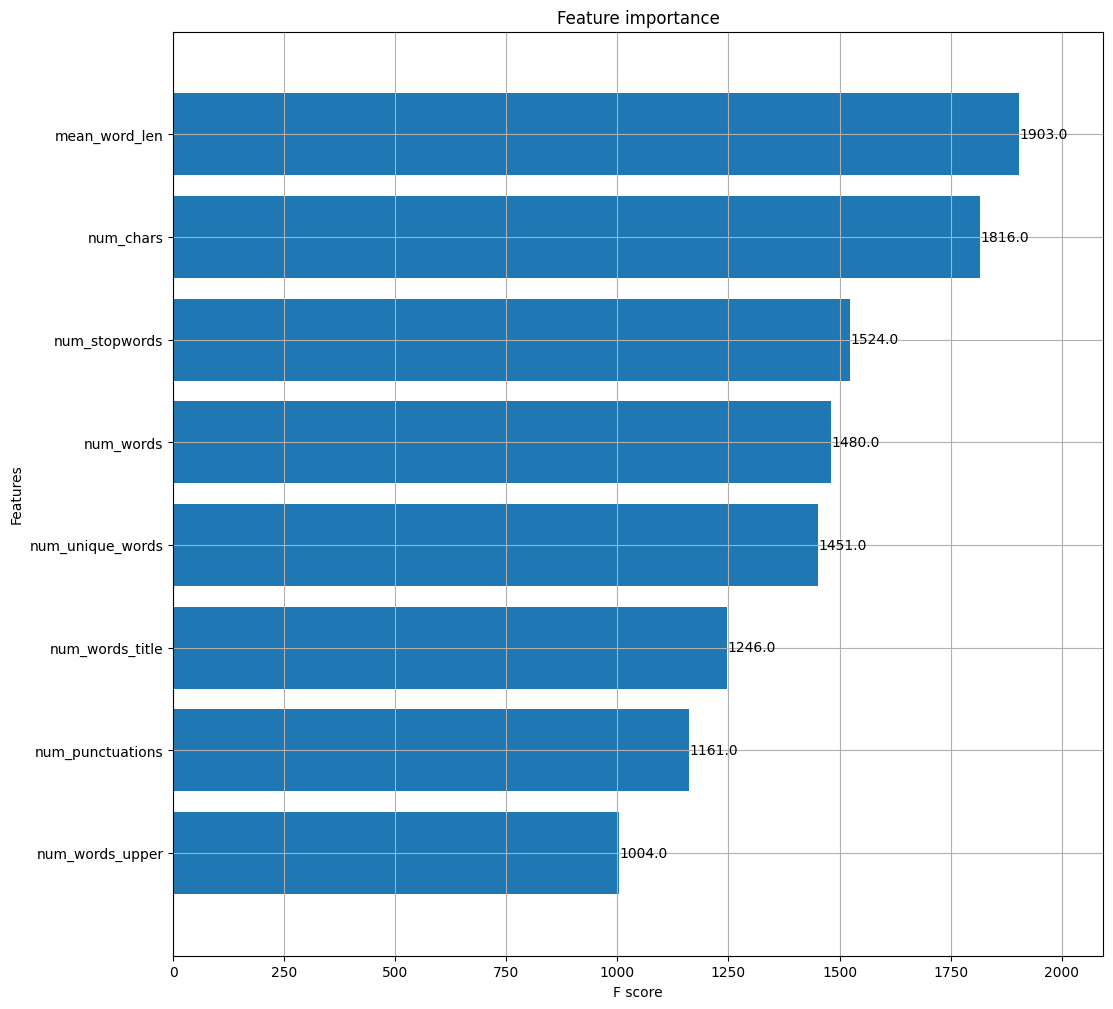

In [21]:
fig, ax = plt.subplots(figsize=(12, 12))
xgb.plot_importance(model, max_num_features = 50, height=0.8, ax=ax)
plt.show()

### Using Text based features

In [23]:
#tf-idf 값 활용해보기
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
# ngram_range=(1,3) 단어 단위(n-gram)로 1-gram, 2-gram, 3-gram 을 모두 고려한다. 즉
# 단어 하나, 두 단어의 조합, 세 단어의 조합을 특징으로 사용한다.
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
# 학습 데이터와 테스트 데이터 간의 단어 사전 동일하게 
# fit_transform: TF-IDF 벡터라이저를 학습(fit)시키고, 
# 동시에 텍스트 데이터를 TF-IDF 행렬로 변환(transform)합니다. 
# full_tfidf는 학습과 테스트 데이터를 모두 포함하는 TF-IDF 행렬이 됩니다.
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [31]:
print(tfidf_vec.get_feature_names_out())
tfidf_vec.get_feature_names_out().shape

['aaem' 'ab' 'ab te' ... 'οἶδα οἶδα' 'οἶδα οἶδα know' 'υπνος']


(550841,)

In [28]:
train_tfidf
# 550841: TF-IDF 벡터의 특징(feature) 수, 즉 고유한 n-그램의 개수.

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 611707 stored elements and shape (19579, 550841)>

Naive Bayes on Word Tfidf Vectorizer

In [32]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [33]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean CV score:", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.   

Mean CV score: 0.8422161983612855


[confusion matrix 시각화] -- 생략

TF-IDF 행렬에 특이값 분해 (SVD)를 적용

In [34]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train= pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)

del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

Naive Bayes on Word Count Vectorizer

In [37]:
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train['text'].values.tolist()+test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

In [39]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index, :] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean CV score:", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.   

train['nb_cvec_eap'] = pred_train[:,0]
train['nb_cvec_hpl'] = pred_train[:,1]
train['nb_cvec_mws'] = pred_train[:,2]
test["nb_cvec_eap"] = pred_full_test[:,0]
test["nb_cvec_hpl"] = pred_full_test[:,1]
test["nb_cvec_mws"] = pred_full_test[:,2]

Mean CV score: 0.45091841616567435


[confusion matrix 시각화] -- 생략

word level 대신 character level!

In [42]:
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
#analyzer parameter 를 char
tfidf_vec.fit(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)

for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train["nb_cvec_char_eap"] = pred_train[:,0]
train["nb_cvec_char_hpl"] = pred_train[:,1]
train["nb_cvec_char_mws"] = pred_train[:,2]
test["nb_cvec_char_eap"] = pred_full_test[:,0]
test["nb_cvec_char_hpl"] = pred_full_test[:,1]
test["nb_cvec_char_mws"] = pred_full_test[:,2]

Mean cv score :  3.8528982526171474


Naive Bayes on Character Tfidf Vectorizer:

In [43]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train['text'].values.tolist() + test['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train["nb_tfidf_char_eap"] = pred_train[:,0]
train["nb_tfidf_char_hpl"] = pred_train[:,1]
train["nb_tfidf_char_mws"] = pred_train[:,2]
test["nb_tfidf_char_eap"] = pred_full_test[:,0]
test["nb_tfidf_char_hpl"] = pred_full_test[:,1]
test["nb_tfidf_char_mws"] = pred_full_test[:,2]

Mean cv score :  0.790415258947421


SVD on Character TFIDF:

In [44]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train = pd.concat([train, train_svd], axis=1)
test = pd.concat([test, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

XGBoost Model

In [45]:
cols_to_drop = ['id', 'text']
train_X = train.drop(cols_to_drop+['author'], axis=1)
test_X = test.drop(cols_to_drop, axis=1)

kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train.shape[0], 3])
for dev_index, val_index in kf.split(train_X):
    dev_X, val_X = train_X.loc[dev_index], train_X.loc[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

out_df = pd.DataFrame(pred_full_test)
out_df.columns = ['EAP', 'HPL', 'MWS']
out_df.insert(0, 'id', test_id)
out_df.to_csv("sub_fe.csv", index=False)

[07:51:14] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	train-mlogloss:1.00241	test-mlogloss:1.00208


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[20]	train-mlogloss:0.40856	test-mlogloss:0.41347
[40]	train-mlogloss:0.33831	test-mlogloss:0.35108
[60]	train-mlogloss:0.31278	test-mlogloss:0.33346
[80]	train-mlogloss:0.29550	test-mlogloss:0.32413
[100]	train-mlogloss:0.28183	test-mlogloss:0.31834
[120]	train-mlogloss:0.27085	test-mlogloss:0.31406
[140]	train-mlogloss:0.26092	test-mlogloss:0.31118
[160]	train-mlogloss:0.25233	test-mlogloss:0.30973
[180]	train-mlogloss:0.24470	test-mlogloss:0.30923
[200]	train-mlogloss:0.23752	test-mlogloss:0.30840
[220]	train-mlogloss:0.23085	test-mlogloss:0.30747
[240]	train-mlogloss:0.22475	test-mlogloss:0.30753
[260]	train-mlogloss:0.21866	test-mlogloss:0.30775
[263]	train-mlogloss:0.21764	test-mlogloss:0.30741
cv scores :  [0.30734905485261926]


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


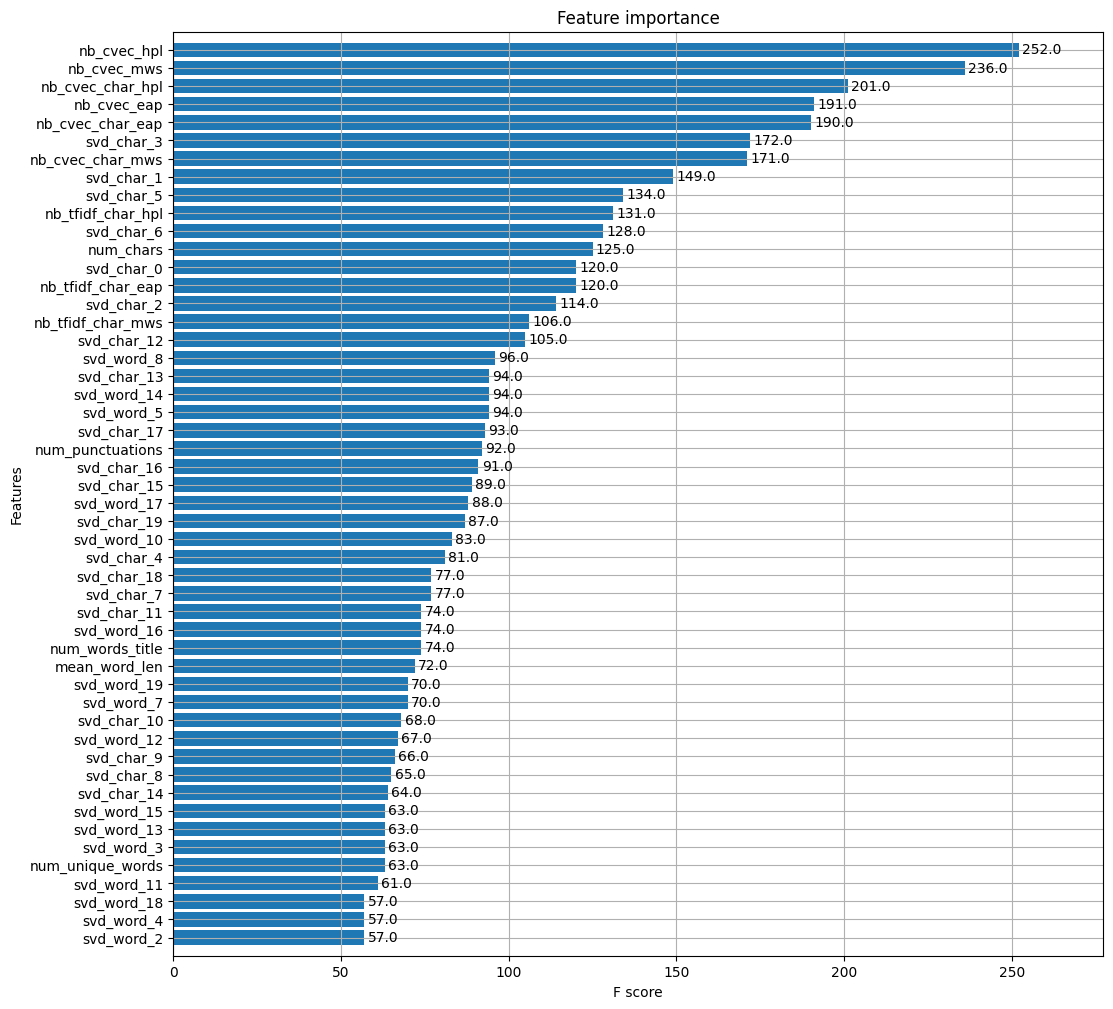

In [46]:
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()